通过skl定义一个简单的数据集:

C:\Users\26295\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[-1.12345435  1.11866507  0.81415339]
 [ 1.15911301  0.3028103   1.1011775 ]
 [-0.49828487  0.07155638  0.23437382]
 ...
 [ 0.49389882  1.68008605  1.91758548]
 [ 0.48627945  0.26752766 -0.2548454 ]
 [-0.42841125  1.89704658 -2.01576541]]
<class 'numpy.ndarray'> (10000, 2)
Figure(640x480) [-0.11234544  0.1159113  -0.04982849 ...  0.04938988  0.04862795
 -0.04284113] [ 0.08141534  0.11011775  0.02343738 ...  0.19175855 -0.02548454
 -0.20157654]
tensor([[-0.1123,  0.0814],
        [ 0.1159,  0.1101],
        [-0.0498,  0.0234],
        ...,
        [ 0.0494,  0.1918],
        [ 0.0486, -0.0255],
        [-0.0428, -0.2016]])


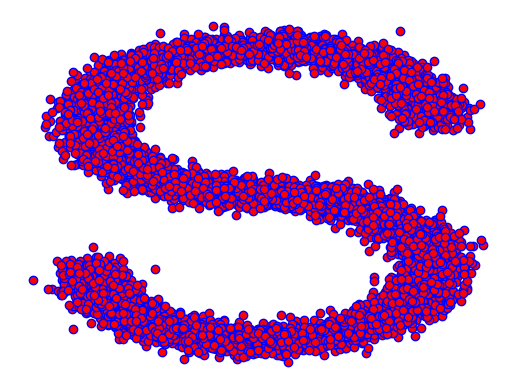

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_s_curve

s_curve,_ = make_s_curve(10000,noise = 0.1)
print(s_curve)
s_curve = s_curve[:,[0,2]]/10.0
s_curve.shape
print(type(s_curve),s_curve.shape)
# print(*s_curve)

data = s_curve.T #转置

fig,ax =plt.subplots();
print(fig,*data)
ax.scatter(*data,color='red',edgecolor = 'blue')
ax.axis('off')

dataset = torch.Tensor(s_curve).float()
print(dataset)

确定超参数的值

In [2]:
num_steps = 100

betas = torch.linspace(-6,6,num_steps)
# print(betas,0.5e-2)
betas = torch.sigmoid(betas)*(0.5e-2-1e-5)+1e-5
# print(betas)

alphas = 1-betas;
# print(alphas)
alphas_prod = torch.cumprod(alphas,0)# 连乘
# print("alpha_prod:",alphas_prod)

alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0) #t-1时刻的连乘结果
# print([torch.tensor([1]).float(),alphas_prod[:-1]],alphas_prod[:-1])
# print("alpha_prod_p:",alphas_prod_p)

alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)


确定扩散过程的任意时刻采样值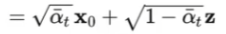
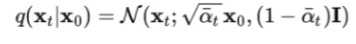


In [3]:
def q_x(x_0,t):
    nosie = torch.randn_like(x_0)
#     print(nosie)
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t*x_0+alphas_l_m_t*nosie)

print(torch.randn_like(torch.tensor([1]).float()))

tensor([-0.2115])


演示原始数据分布加噪100的结果

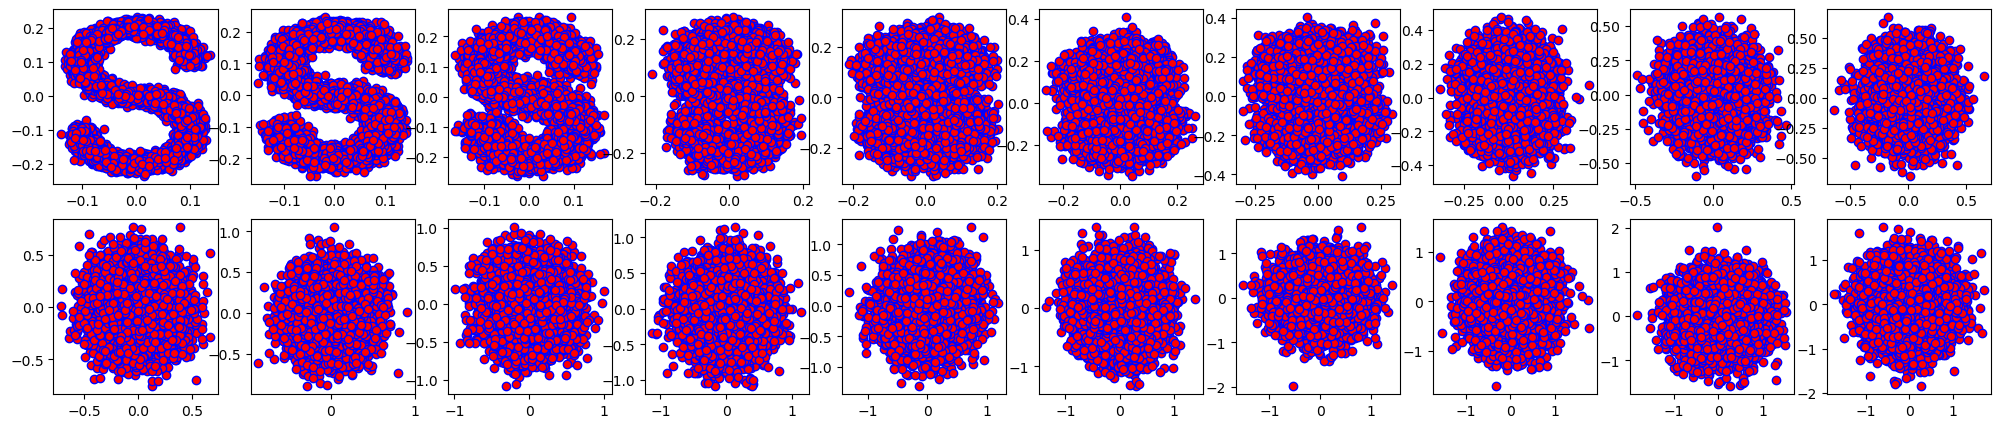

In [4]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(25,5))
plt.rc('text',color='blue')

for i in range(num_shows):
    j=i//10 #整除
    k=i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) #每隔5个时间绘制一幅图像
#     q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='blue')
    


编写逆扩散过程高斯分布模型

In [5]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init_(self,n_steps,num_units = 128):
        super(MLPDiffusion,self).__init_()
        
        self.linears = nn.ModuleList([
            nn.Linear(2,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,2),
        ])
        self.step_embeddings =nn.ModuleList([
            
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
        ])
    
    def forward(self,x,t):
        
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x+=t_embedding
            x=self.linears[2*idx+1](x)
        x=self.linears[-1](x)
        
        return x

误差函数的编写：
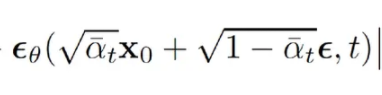

In [6]:
t = torch.randint(0,100,size=(5000,))
print(t,t.shape)
t = torch.cat([t,100-1-t],dim=0)
print(t,t.shape)
t = t.unsqueeze(0)
print(t,t.shape)
t = t.unsqueeze(-1)
print(t,t.shape)
# t = t.unsqueeze(-1)
# print(t,t.shape)
t = t.squeeze(-1)
print(t,t.shape)
t = t.squeeze(0)
print(t,t.shape)

tensor([16, 36, 56,  ..., 19,  7, 94]) torch.Size([5000])
tensor([16, 36, 56,  ..., 80, 92,  5]) torch.Size([10000])
tensor([[16, 36, 56,  ..., 80, 92,  5]]) torch.Size([1, 10000])
tensor([[[16],
         [36],
         [56],
         ...,
         [80],
         [92],
         [ 5]]]) torch.Size([1, 10000, 1])
tensor([[16, 36, 56,  ..., 80, 92,  5]]) torch.Size([1, 10000])
tensor([16, 36, 56,  ..., 80, 92,  5]) torch.Size([10000])


In [7]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    
    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0系数
    a = alphas_bar_sqrt[t]
    
    aml = one_minus_alphas_bar_sqrt[t]
    
    e = torch.randn_like(x_0)
    
    x=x_0*a+e*aml
    
    output = model(x,t.squeeze(-1))
    
    return (e-output).square().mean()
    
    

编写逆扩散采样函数
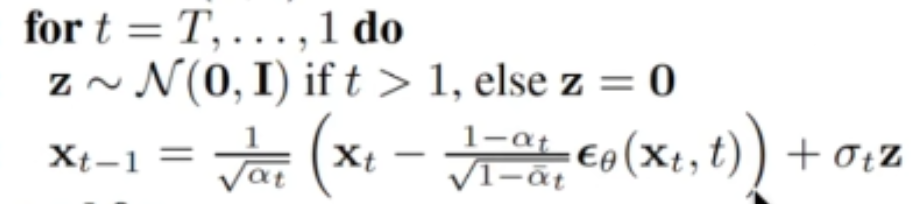

In [8]:
reversed(range(num_steps))

In [9]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
#     从xT 恢复 xT-1 。。。X0
    
    cur_x = torch.randn(shape)
    
    x_seq =[cur_x]
    
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    
    coeff = betas[t]/one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean =(1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z=torch.randn_like(x)
    
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t *z
    
    return (sample)
    

训练模型，打印loss

In [ ]:
seed = 1234

class EMA() 
#参数平滑器
    def __init__(self,mu = 0.01):
        self.mu = mu
        self.shadow  = {}
    
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu*x +(1.0 - self.mu)*self.shadow(name)
        self.shadow[name] = new_average.clone()
        return new_average